## Political Orientation prediction of Reddit users: a supervised and unsupervised approach

As political polarization grows around the world (Gidron, Adams & Horne, 2019; Pew Research Center, 2017), social media platforms are progressively becoming more like arenas where individuals defend their own ideas and attack others (Tucker et al., 2018). In this research we test an approach to predict political orientation of social media users by using textual data shared on Reddit.
Our analysis is composed of the following steps: 

1. Collect users' posts through Reddit's public APIs (PRAW)
2. Manually annotate subreddits into Political/Non-Political. Political subreddits are then further labeled as either Conservatives or Democrats or Undecided.
3. Automatically assign a label (Conservative, Democrat, Undecided) to each user by:
    - computing label_score (score that consider the sum of upvotes received in each subreddit of the same label)
    - apply k-means clustering to assign a binary (Dem, Cons) categorical variable to each user through their parties' previously calculated label_score
4. For each user:
    - calculate the average of their moral foundation scores
    - visualizing the differences between Conservative, Democrat and Undecided labeled users (give me ideas for more visualizations idk what to do)
5. Test models

In [211]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/scores.csv")
political_subreddits = pd.read_csv("./data/political_subreddits.csv")

In [212]:
from data_collection.collector import DataCollector
import logging
import os
import json
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

credentials_json = os.getenv('REDDIT_API_CREDENTIALS')
credentials = json.loads(credentials_json)[0]

def get_member_counts(subreddits):
    collector = DataCollector(**credentials)
    subreddits_members = []

    for idx, sub in subreddits.iterrows():
        try:
            member_count = collector.get_subreddit_member_count(sub.subreddit)
            subreddit = {"subreddit": sub.subreddit, "member_count": member_count, "label": sub.label }
            subreddits_members.append(subreddit)
        except Exception as e:
            print(f"{e}: {sub.subreddit}")

    return pd.DataFrame(subreddits_members)

subreddits_members = get_member_counts(political_subreddits)
subreddits_members.head()

Redirect to /subreddits/search: moderatespolitics
received 403 HTTP response: liberals
received 404 HTTP response: progressivist
Redirect to /subreddits/search: commie_memes
Redirect to /subreddits/search: workersrevolt
Redirect to /subreddits/search: greenpeacedawn
received 403 HTTP response: progressiverevolution


,subreddit,member_count,label
0,conservative,1155285,c
1,askconservatives,23280,c
2,republican,206568,c
3,conservatives,108300,c
4,twoxconservatives,145,c


<!-- language of the users

0. annotate subreddits in terms of political views w many llms (claude, gpt, gemini) and assess quality of annotation (IAA inter annotator agreement)
1. get the member count for every subreddit - v 
2. compute karma/(subreddit member count) 
3. group by political label and see distributions of karma 
4. from step 3 distribution get the threshold using percentiles (of karma)
5. read random posts near threshold and qualitatvely estimate the political polarization 
6. adjust threshold and redo 5 till convergence
7. study the morality pattern of grouped by users and see the differences between two labels
    (explain whether the results replicate past research)
    7.5 check the time series
8. is the data good enough to make predictions of political orientation regardless of the theory given the collected post features (not our scores) -->


In [213]:
def filter_political_subreddits(df, df_political_subreddits):
    return df[df["subreddit"].isin(df_political_subreddits["subreddit"].to_list())]

def merge_subreddit_members(df, df_subreddit_members):
        df = df.merge(right=df_subreddit_members, how="left", on=["subreddit"])
        df = df.drop(columns=[col for col in df.columns if col.endswith('_x')])
        df.columns = [col.replace('_y', '') for col in df.columns]
        df["member_count"] = df["member_count"].fillna(df["member_count"].mean())
        df["label"] = df["label"].fillna("-")
    
        return df


In [214]:
data = data.copy()
filtered_data = filter_political_subreddits(data, political_subreddits)

data, filtered_data = merge_subreddit_members(data, subreddits_members) , merge_subreddit_members(filtered_data, subreddits_members )

In [215]:
def make_positive(column):
    if column.min() < 0:
        return column - column.min() + 2
    return column

get the logarithm of the average of karma ob

\[
\begin{aligned}
\text{Step 1: Compute average karma per user per subreddit:} \\
\mu_{\text{user, subreddit}} &= \frac{\sum \text{score}_{\text{user, subreddit}}}{N_{\text{posts, user, subreddit}}}
\end{aligned}
\]

\[
\begin{aligned}
\text{Step 2: Normalize by member count:} \\
\omega_{\text{user, subreddit}} &= 
\log\left(\frac{\mu_{\text{user, subreddit}}}{M_{\text{subreddit}}} + \epsilon \right)
\end{aligned}
\]

\[
\begin{aligned}
\text{Step 3: Aggregate by label and username:} \\
S_{\text{label}} &= \sum_{\text{subreddits}} \omega_{\text{user, subreddit}}
\end{aligned}
\]

\[
\begin{aligned}
\text{Step 4: Apply positivity correction:} \\
\phi(x) &= 
\begin{cases} 
x - \min(x) + \epsilon, & \text{if } \min(x) < 0 \\
x, & \text{otherwise}
\end{cases} \\
S_{\text{label}} &= \log\left(\phi(S_{\text{label}})\right)
\end{aligned}
\]


In [216]:
def transform_data(df):
    grouped = df.groupby(by=["username", "subreddit"])["score"].mean().reset_index(name=f"avg_user_subreddit_karma")
    transformed_data = df.merge(right=grouped, on=["username", "subreddit"], how="left")

    # Weight by member count
    transformed_data["avg_user_subreddit_karma_per_member_count"] = (
        transformed_data["avg_user_subreddit_karma"] / (transformed_data["member_count"])
    ) + 1e-9
    transformed_data["avg_user_subreddit_karma_per_member_count"] = np.log(
        make_positive(transformed_data["avg_user_subreddit_karma_per_member_count"])
    )

    # Aggregate total karma by label and username
    grouped = transformed_data.groupby(by=["label", "username"])["avg_user_subreddit_karma_per_member_count"].sum().reset_index(name="label_score")
    transformed_data = transformed_data.merge(right=grouped, how="left", on=["label", "username"])

    # Ensure label_score is positive before taking log
    transformed_data["label_score"] = np.log(make_positive(transformed_data["label_score"]))

    return transformed_data


In [217]:
transformed_data = transform_data(filtered_data)
# transformed_data_prime = transform_data(data)

In [218]:
# transformed_data["member_count"].isna().sum()

Average of the karma distribution per each label looks similar in subreddits of both political labels.
This result suggests that user's of both subreddits group have similar upvote behaviours. With democrats showing a higher average.
The distribution is skewed in both groups, suggesting a high influence of very popular submissions.
It is also possible to notice differences in left tails in both groups.
In fact, democrats left tail suggest that posts on liberal subreddits tend to receive far more downvotes then conservatives ones.
In general, democrats subreddits appear to have a higher variability. This can be due to lower general member counts between the two groups as show in the earlier plots.

In [221]:
import pandas as pd

def add_party_scores(data: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the transformed data by performing pivoting, normalization, and merging.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing 'username', 'label', and 'label_score'.

    Returns:
        pd.DataFrame: The updated DataFrame after processing.
    """
    # Pivot the data
    pivoted = data.pivot_table(
        index=["username"], 
        columns="label", 
        values="label_score", 
        fill_value=0
    ).reset_index()

    # Normalize columns 'c' and 'd'
    for col in ["c", "d"]:
        pivoted[col] = (pivoted[col] - pivoted[col].mean()) / pivoted[col].std()

    # Calculate the difference between 'c' and 'd'
    pivoted["c_d"] = pivoted["c"] - pivoted["d"]

    # Merge the pivoted data back into the original data
    result = data.merge(right=pivoted, on="username", how="left")
    
    return result

transformed_data = add_party_scores(transformed_data)
# transformed_data_prime = add_party_scores(transformed_data_prime)


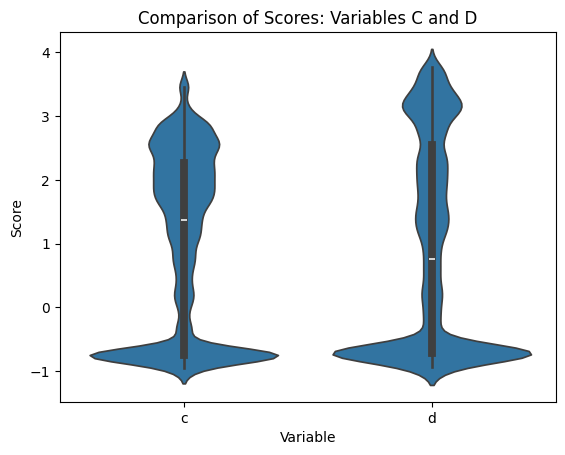

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

df_melted = transformed_data[["c", "d"]].melt(var_name="Variable", value_name="Score")

sns.violinplot(data=df_melted, x="Variable", y="Score")
plt.title("Comparison of Scores: Variables C and D")
plt.xlabel("Variable")
plt.ylabel("Score")
plt.show()


In [223]:
transformed_data[["username", "c", "d"]].head()

,username,c,d
0,laserfartt,1.230716,1.232301
1,laserfartt,1.230716,1.232301
2,laserfartt,1.230716,1.232301
3,laserfartt,1.230716,1.232301
4,laserfartt,1.230716,1.232301


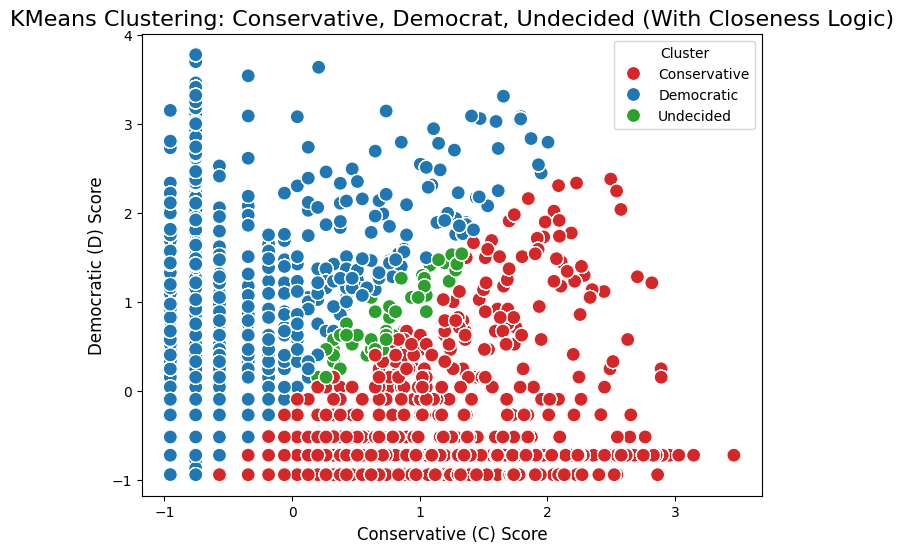

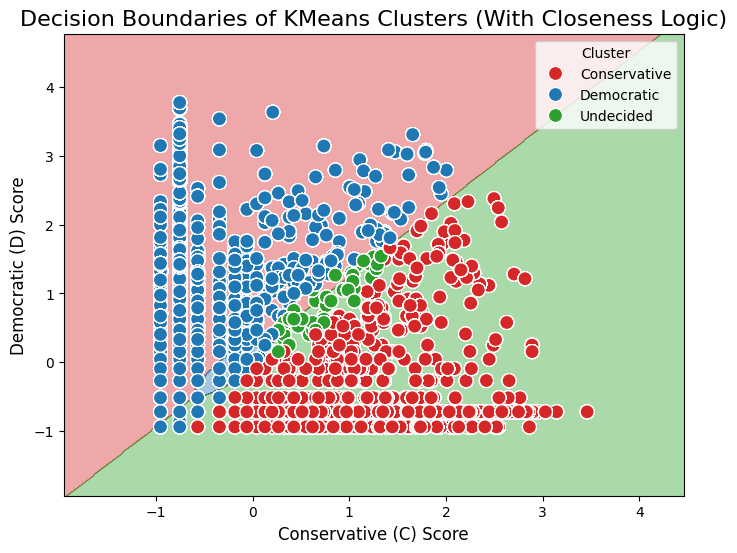

In [224]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap


COLOR_PALETTE = {
    "Conservative": "#d62728",
    "Democratic": "#1f77b4",
    "Undecided": "#2ca02c"
}

def preprocess_data(data, features):
    """Standardize the features in the dataset."""
    scaler = StandardScaler()
    return scaler.fit_transform(data[features])

def perform_kmeans_clustering(X, n_clusters=3):
    """Perform KMeans clustering and return labels and centroids."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    return labels, centroids

def assign_clusters_with_penalty(X, centroids, proximity_threshold):
    """Assign clusters with penalty for proximity to decision boundaries."""
    distances_to_centroids = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels_with_penalty = []

    for i, point in enumerate(X):
        distance_to_conservative = distances_to_centroids[i, conservative_cluster]
        distance_to_democratic = distances_to_centroids[i, democratic_cluster]

        if distance_to_conservative < proximity_threshold and distance_to_democratic < proximity_threshold:
            labels_with_penalty.append(undecided_cluster)
        elif distance_to_conservative < distance_to_democratic:
            labels_with_penalty.append(conservative_cluster)
        else:
            labels_with_penalty.append(democratic_cluster)

    return labels_with_penalty

def map_cluster_labels(labels, cluster_labels):
    """Map numeric cluster labels to descriptive labels."""
    return [cluster_labels[label] for label in labels]

def plot_data_with_clusters(data, x_feature, y_feature, cluster_col, palette, title):
    """Plot scatter plot of data with clusters."""
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=data,
        x=x_feature,
        y=y_feature,
        hue=cluster_col,
        palette=palette,
        s=100,
        hue_order=["Conservative", "Democratic", "Undecided"]
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Conservative (C) Score", fontsize=12)
    plt.ylabel("Democratic (D) Score", fontsize=12)
    plt.legend(title="Cluster", loc='best')
    plt.show()

def plot_decision_boundaries(xx, yy, penalty_labels, custom_cmap, data, x_feature, y_feature, cluster_col, palette):
    """Plot decision boundaries with penalty logic."""
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, penalty_labels, alpha=0.4, cmap=custom_cmap)
    sns.scatterplot(
        data=data,
        x=x_feature,
        y=y_feature,
        hue=cluster_col,
        palette=palette,
        s=100,
        hue_order=["Conservative", "Democratic", "Undecided"]
    )
    plt.title("Decision Boundaries of KMeans Clusters (With Closeness Logic)", fontsize=16)
    plt.xlabel("Conservative (C) Score", fontsize=12)
    plt.ylabel("Democratic (D) Score", fontsize=12)
    plt.legend(title="Cluster", loc='best')
    plt.show()

def detect_parties(data, proximity_threshold=1.5, plot_data=False):
    """Process data through clustering and visualization pipeline."""
    def plot(data):
        plot_data_with_clusters(
            data, "c", "d", "party", COLOR_PALETTE,
            "KMeans Clustering: Conservative, Democrat, Undecided (With Closeness Logic)"
        )

        # Generate mesh grid for decision boundaries
        x_min, x_max = data['c'].min() - 1, data['c'].max() + 1
        y_min, y_max = data['d'].min() - 1, data['d'].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

        # Apply penalty logic to classify grid points
        penalty_labels = []
        for point in np.c_[xx.ravel(), yy.ravel()]:
            distances = np.linalg.norm(point - centroids, axis=1)
            distance_to_conservative = distances[conservative_cluster]
            distance_to_democratic = distances[democratic_cluster]

            if distance_to_conservative < proximity_threshold and distance_to_democratic < proximity_threshold:
                penalty_labels.append(undecided_cluster)
            elif distance_to_conservative < distance_to_democratic:
                penalty_labels.append(conservative_cluster)
            else:
                penalty_labels.append(democratic_cluster)

        penalty_labels = np.array(penalty_labels).reshape(xx.shape)
        custom_cmap = ListedColormap(["#2ca02c", "#d62728", "#1f77b4"])

        # Plot decision boundaries
        plot_decision_boundaries(xx, yy, penalty_labels, custom_cmap, data, "c", "d", "party", COLOR_PALETTE)

    X = preprocess_data(data, ["c", "d"])
    labels, centroids = perform_kmeans_clustering(X)

    # Calculate score differences
    score_differences = centroids[:, 0] - centroids[:, 1]
    global conservative_cluster, democratic_cluster, undecided_cluster
    undecided_cluster = np.argmin(np.abs(score_differences))
    conservative_cluster = np.argmax(score_differences)
    democratic_cluster = 3 - undecided_cluster - conservative_cluster

    # Map numeric clusters to descriptive labels
    cluster_labels = {
        conservative_cluster: "Conservative",
        democratic_cluster: "Democratic",
        undecided_cluster: "Undecided"
    }

    # Assign clusters with penalty logic
    labels_with_penalty = assign_clusters_with_penalty(X, centroids, proximity_threshold)

    # Map clusters to descriptive labels
    data['party'] = map_cluster_labels(labels_with_penalty, cluster_labels)

    if plot_data:
        plot(data)

    return data



# Apply process to both datasets
transformed_data = detect_parties(transformed_data, 1.5, plot_data=True)
transformed_data_prime = detect_parties(transformed_data_prime)



In [225]:
transformed_data[transformed_data["username"] == "coddle_muh_feefees"][["username", "party", "selftext"]]

,username,party,selftext
88428,coddle_muh_feefees,Democratic,wtf is he going on about Canada?
88429,coddle_muh_feefees,Democratic,Stop parroting Fox “News” talking points. Thes...
88430,coddle_muh_feefees,Democratic,"It is Friday, I need to give my F5 key a workout"
88431,coddle_muh_feefees,Democratic,"If the GOP, excuse me, The Trump Party, didn’t..."
88432,coddle_muh_feefees,Democratic,But what about the price of eggs?/sI’m in this...
...,...,...,...
88489,coddle_muh_feefees,Democratic,NaN
88490,coddle_muh_feefees,Democratic,NaN
88491,coddle_muh_feefees,Democratic,NaN
88492,coddle_muh_feefees,Democratic,NaN


C:\Users\Administrator\AppData\Local\Temp\ipykernel_332\3506468202.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


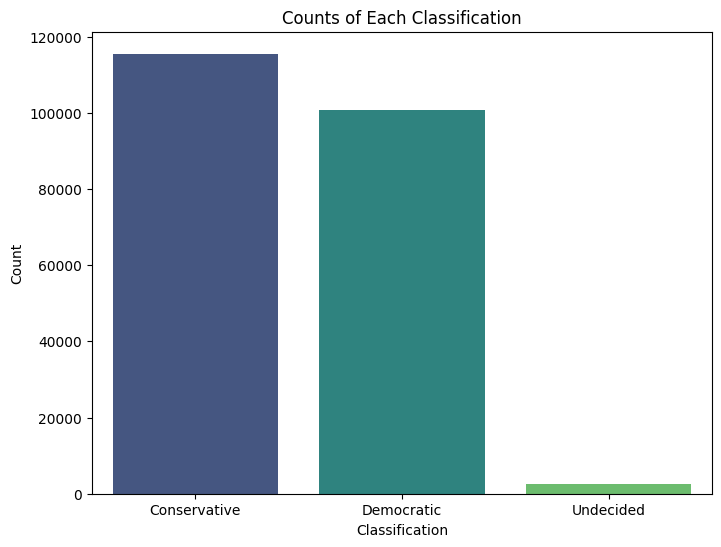

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_classification_counts(data, column_name):
    """
    Plots the counts of each classification in the specified column of the data.

    Parameters:
        data (pd.DataFrame): The input DataFrame containing the classification column.
        column_name (str): The name of the column to count and plot.
    """
    # Get value counts for the specified column
    class_counts = data[column_name].value_counts()

    # Plot the counts for each classification
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

    plt.xlabel('Classification')
    plt.ylabel('Count')
    plt.title('Counts of Each Classification')

    plt.show()

plot_classification_counts(transformed_data, 'party')


todo: 
1. which karma threshold (help us annotate users as cons or liberal) by looking at the distribution of the subreddit
2. visualizations (studying distribution of karma [see 1.], distribution of intensity, bias between the groups)
    
    - boxplots
    - qq-plots
    - pca/tsne
    - distribution of target (barplot)
    - time series nearby elections data
    - data quality (missing values, duplicates)

3. linking the methods to the topics



In [227]:
transformed_data.shape

(218820, 40)

In [228]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'df' is your DataFrame
# # Parse 'posted_time' as datetime
# transformed_data['posted_time'] = pd.to_datetime(transformed_data['posted_time'])

# # Filter data starting from 2014
# df = transformed_data

# grouped = df.groupby(['username']).agg({
#     'bias_fairness': 'mean',
#     'bias_care': 'mean',
#     'bias_authority': 'mean',
#     'bias_loyalty': 'mean',
#     'bias_sanctity': 'mean',
#     'intensity_fairness': 'mean',
#     'intensity_care': 'mean',
#     'intensity_authority': 'mean',
#     'intensity_loyalty': 'mean',
#     'intensity_sanctity': 'mean'
# }).reset_index()

# # Filter out 'Undecided' party
# grouped_no_undecided  = grouped[grouped['party'] != 'Undecided']

# # Define a custom color palette for parties
# party_colors = {
#     'Democratic': 'blue',
#     'Conservative': 'red',
#     'Undecided': 'green'
# }

# # Plot each bias dimension over time with all parties in the same plot
# bias_dimensions = ['bias_fairness', 'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity']
# for dimension in bias_dimensions:
#     g = sns.lineplot(data=grouped_no_undecided, x='quarter', y=dimension, hue='party', palette=party_colors, marker='o')
#     g.set(title=f'{dimension.replace("_", " ").capitalize()} Over Time by Party', xlabel='Time (Quarter)', ylabel=dimension.replace("_", " ").capitalize())
#     plt.xticks(rotation=45)
#     plt.legend(title='Party')
#     plt.tight_layout()
#     plt.show()

# # Plot each intensity dimension over time with all parties in the same plot
# intensity_dimensions = ['intensity_fairness', 'intensity_care', 'intensity_authority', 'intensity_loyalty', 'intensity_sanctity']
# for dimension in intensity_dimensions:
#     g = sns.lineplot(data=grouped_no_undecided, x='quarter', y=dimension, hue='party', palette=party_colors, marker='o')
#     g.set(title=f'{dimension.replace("_", " ").capitalize()} Over Time by Party', xlabel='Time (Quarter)', ylabel=dimension.replace("_", " ").capitalize())
#     plt.xticks(rotation=45)
#     plt.legend(title='Party')
#     plt.tight_layout()
#     plt.show()


In [229]:
transformed_data.columns

Index(['username', 'title', 'selftext', 'subreddit', 'score', 'num_comments',
       'posted_time', 'submission_type', 'fulltext', 'bias_fairness',
       'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity',
       'intensity_fairness', 'intensity_care', 'intensity_authority',
       'intensity_loyalty', 'intensity_sanctity', 'fairness.vice',
       'fairness.virtue', 'care.virtue', 'care.vice', 'authority.virtue',
       'authority.vice', 'loyalty.vice', 'loyalty.virtue', 'sanctity.vice',
       'sanctity.virtue', 'member_count', 'label', 'avg_user_subreddit_karma',
       'avg_user_subreddit_karma_per_member_count', 'label_score', 'C', 'c',
       'd', 'dd', 'c_d', 'party'],
      dtype='object')

In [230]:
grouped = transformed_data.groupby(['username']).agg({
    'bias_fairness': 'mean',
    'bias_care': 'mean',
    'bias_authority': 'mean',
    'bias_loyalty': 'mean',
    'bias_sanctity': 'mean',
    'intensity_fairness': 'mean',
    'intensity_care': 'mean',
    'intensity_authority': 'mean',
    'intensity_loyalty': 'mean',
    'intensity_sanctity': 'mean', 
    'fairness.vice': 'mean',
    'fairness.virtue': 'mean', 
    'care.virtue': 'mean', 
    'care.vice': 'mean', 
    'authority.virtue': 'mean',
    'authority.vice': 'mean', 
    'loyalty.vice': 'mean', 
    'loyalty.virtue': 'mean', 
    'sanctity.vice': 'mean',
    'sanctity.virtue': 'mean',
    'party': lambda x: x.mode()[0]
}).reset_index()

print(grouped.columns)


Index(['username', 'bias_fairness', 'bias_care', 'bias_authority',
       'bias_loyalty', 'bias_sanctity', 'intensity_fairness', 'intensity_care',
       'intensity_authority', 'intensity_loyalty', 'intensity_sanctity',
       'fairness.vice', 'fairness.virtue', 'care.virtue', 'care.vice',
       'authority.virtue', 'authority.vice', 'loyalty.vice', 'loyalty.virtue',
       'sanctity.vice', 'sanctity.virtue', 'party'],
      dtype='object')


In [231]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# # Define dimensions and color palette
# bias_dimensions = ['bias_fairness', 'bias_care', 'bias_authority', 'bias_loyalty', 'bias_sanctity']
# intensity_dimensions = ['intensity_fairness', 'intensity_care', 'intensity_authority', 'intensity_loyalty', 'intensity_sanctity']

# party_colors = {
#     'Democratic': 'blue',
#     'Conservative': 'red',
#     'Undecided': 'green'
# }

# # Violin plots for bias dimensions
# for dimension in bias_dimensions:
#     plt.figure(figsize=(8, 6))
#     sns.violinplot(data=grouped, x='party', y=dimension, palette=party_colors, inner="quartile")
#     plt.title(f'Distribution of {dimension.replace("_", " ").capitalize()} by Party')
#     plt.xlabel('Party')
#     plt.ylabel(dimension.replace("_", " ").capitalize())
    
#     # Manually create legend handles
#     legend_labels = ['Democratic', 'Conservative', 'Undecided']
#     legend_colors = [party_colors[label] for label in legend_labels if label in grouped['party'].unique()]
#     legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    
#     # Set the custom legend
#     plt.legend(handles=legend_handles, title='Party', loc='upper right')
    
#     plt.tight_layout()
#     plt.show()

# # Violin plots for intensity dimensions
# for dimension in intensity_dimensions:
#     plt.figure(figsize=(8, 6))
#     sns.violinplot(data=grouped, x='party', y=dimension, palette=party_colors, inner="quartile")
#     plt.title(f'Distribution of {dimension.replace("_", " ").capitalize()} by Party')
#     plt.xlabel('Party')
#     plt.ylabel(dimension.replace("_", " ").capitalize())
    
#     # Manually create legend handles
#     legend_labels = ['Democratic', 'Conservative', 'Undecided']
#     legend_colors = [party_colors[label] for label in legend_labels if label in grouped['party'].unique()]
#     legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    
#     # Set the custom legend
#     plt.legend(handles=legend_handles, title='Party', loc='upper right')
    
#     plt.tight_layout()
#     plt.show()


In [232]:
grouped.columns

Index(['username', 'bias_fairness', 'bias_care', 'bias_authority',
       'bias_loyalty', 'bias_sanctity', 'intensity_fairness', 'intensity_care',
       'intensity_authority', 'intensity_loyalty', 'intensity_sanctity',
       'fairness.vice', 'fairness.virtue', 'care.virtue', 'care.vice',
       'authority.virtue', 'authority.vice', 'loyalty.vice', 'loyalty.virtue',
       'sanctity.vice', 'sanctity.virtue', 'party'],
      dtype='object')

Training Logistic Regression on Regular Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5734
Test accuracy for Logistic Regression: 0.5638
------------------------------------------------------------
Training Random Forest on Regular Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.6611
Test accuracy for Random Forest: 0.6483
------------------------------------------------------------
Training Gradient Boosting on Regular Dataset...
Cross-validation accuracy: 0.6619
Test accuracy for Gradient Boosting: 0.6276
------------------------------------------------------------
Training LDA on Regular Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

Cross-validation accuracy: 0.5769
Test accuracy for LDA: 0.5621
------------------------------------------------------------
Training QDA on Regular Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Cross-validation accuracy: 0.5415
Test accuracy for QDA: 0.5724
------------------------------------------------------------
Training KNN on Regular Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5998
Test accuracy for KNN: 0.6034
------------------------------------------------------------
Training SVM on Regular Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.6766
Test accuracy for SVM: 0.6552
------------------------------------------------------------
Training Naive Bayes on Regular Dataset...
Cross-validation accuracy: 0.3929
Test accuracy for Naive Bayes: 0.4276
------------------------------------------------------------


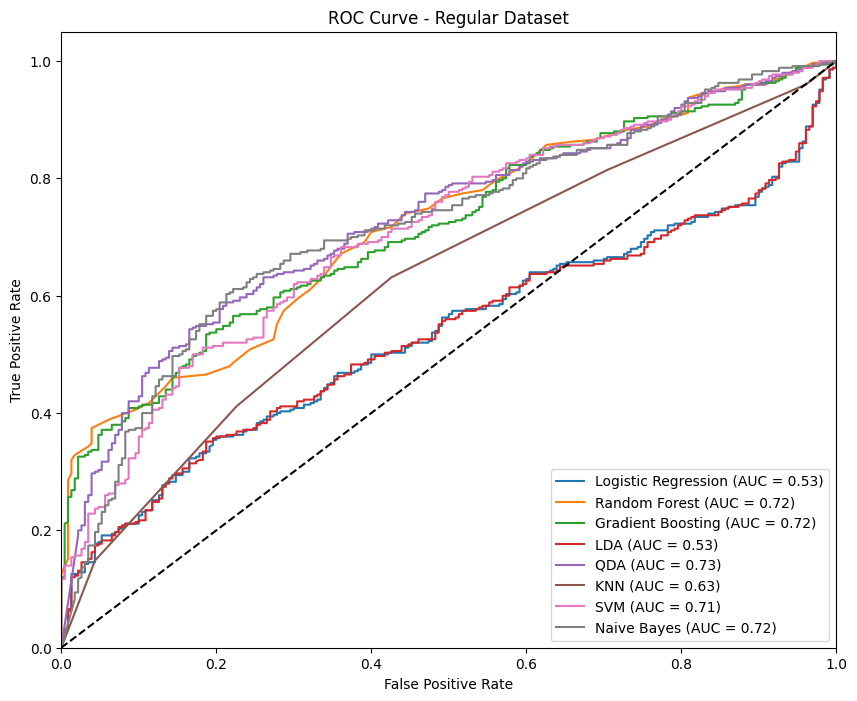

Training Logistic Regression on PCA Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5825
Test accuracy for Logistic Regression: 0.5828
------------------------------------------------------------
Training Random Forest on PCA Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.6550
Test accuracy for Random Forest: 0.6379
------------------------------------------------------------
Training Gradient Boosting on PCA Dataset...
Cross-validation accuracy: 0.6567
Test accuracy for Gradient Boosting: 0.6534
------------------------------------------------------------
Training LDA on PCA Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.5846
Test accuracy for LDA: 0.5828
------------------------------------------------------------
Training QDA on PCA Dataset...
Cross-validation accuracy: 0.5738
Test accuracy for QDA: 0.6017
------------------------------------------------------------
Training KNN on PCA Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Cross-validation accuracy: 0.6041
Test accuracy for KNN: 0.5862
------------------------------------------------------------
Training SVM on PCA Dataset...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

Cross-validation accuracy: 0.6632
Test accuracy for SVM: 0.6448
------------------------------------------------------------
Training Naive Bayes on PCA Dataset...
Cross-validation accuracy: 0.5786
Test accuracy for Naive Bayes: 0.6034
------------------------------------------------------------


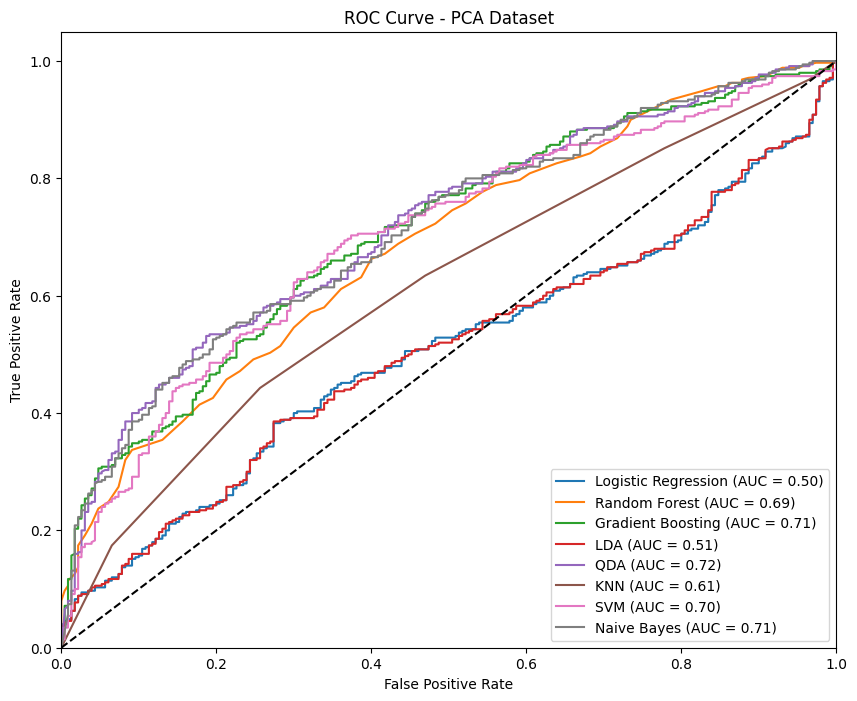


Performance Summary - Regular Dataset
                 Model  CV Accuracy Mean  Test Accuracy  \
0  Logistic Regression          0.573404       0.563793   
1        Random Forest          0.661060       0.648276   
2    Gradient Boosting          0.661934       0.627586   
3                  LDA          0.576859       0.562069   
4                  QDA          0.541450       0.572414   
5                  KNN          0.599751       0.603448   
6                  SVM          0.676604       0.655172   
7          Naive Bayes          0.392924       0.427586   

                               Classification Report  \
0  {'Conservative': {'precision': 0.1891891891891...   
1  {'Conservative': {'precision': 0.5642458100558...   
2  {'Conservative': {'precision': 0.5279187817258...   
3  {'Conservative': {'precision': 0.1842105263157...   
4  {'Conservative': {'precision': 0.4845360824742...   
5  {'Conservative': {'precision': 0.4942528735632...   
6  {'Conservative': {'precision': 0.5

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Assuming 'grouped' DataFrame is available
X = grouped.drop(columns=['party'])  
y = grouped['party']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define numeric features for preprocessing
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),  # Handle missing values
    StandardScaler()  # Scale the numeric features
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
pca_pipeline = make_pipeline(preprocessor, pca)

# Transform datasets
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

# Function to train and evaluate models
def evaluate_models(X_train, X_test, dataset_name):
    results = []
    plt.figure(figsize=(10, 8))  # Initialize the plot for ROC curves
    plt.title(f'ROC Curve - {dataset_name}')

    for model_name, model in models.items():
        print(f"Training {model_name} on {dataset_name}...")
        
        # Create a pipeline with preprocessing and the model
        pipeline = make_pipeline(preprocessor if dataset_name == 'Regular Dataset' else pca, model)

        # Cross-validation to evaluate model performance
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        cv_mean_score = cv_scores.mean()

        # Train the model
        pipeline.fit(X_train, y_train)

        # Predictions
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)  # Probabilities for ROC curve

        # Model evaluation
        classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
        confusion_mat = confusion_matrix(y_test, y_pred)

        # Collect results in a structured way
        results.append({
            'Model': model_name,
            'CV Accuracy Mean': cv_mean_score,
            'Test Accuracy': (y_pred == y_test).mean(),
            'Classification Report': classification_rep,
            'Confusion Matrix': confusion_mat
        })

        print(f"Cross-validation accuracy: {cv_mean_score:.4f}")
        print(f"Test accuracy for {model_name}: {(y_pred == y_test).mean():.4f}")
        print('-' * 60)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)  # For binary classification
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for this model
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Finalize ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    return pd.DataFrame(results)

# Evaluate on both datasets
results_regular = evaluate_models(X_train, X_test, 'Regular Dataset')
results_pca = evaluate_models(X_train_pca, X_test_pca, 'PCA Dataset')

# Display performance summaries
print("\nPerformance Summary - Regular Dataset")
print(results_regular)

print("\nPerformance Summary - PCA Dataset")
print(results_pca)


Training Logistic Regression...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Random Forest...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Gradient Boosting...
Training LDA...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

Training QDA...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Training KNN...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training SVM...


c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\emfd\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Naive Bayes...


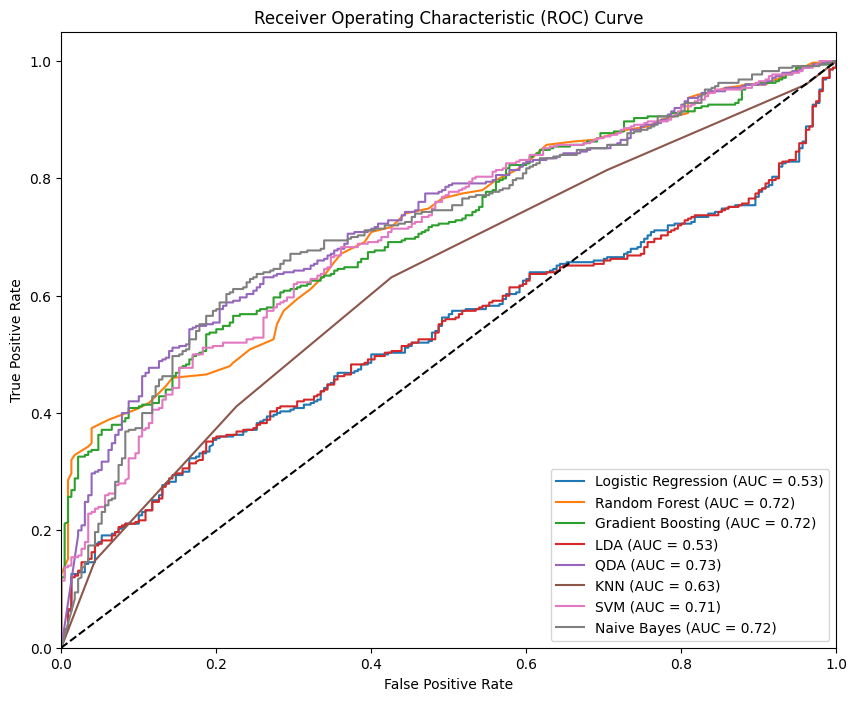

Training Logistic Regression...
Training Random Forest...


KeyboardInterrupt: 

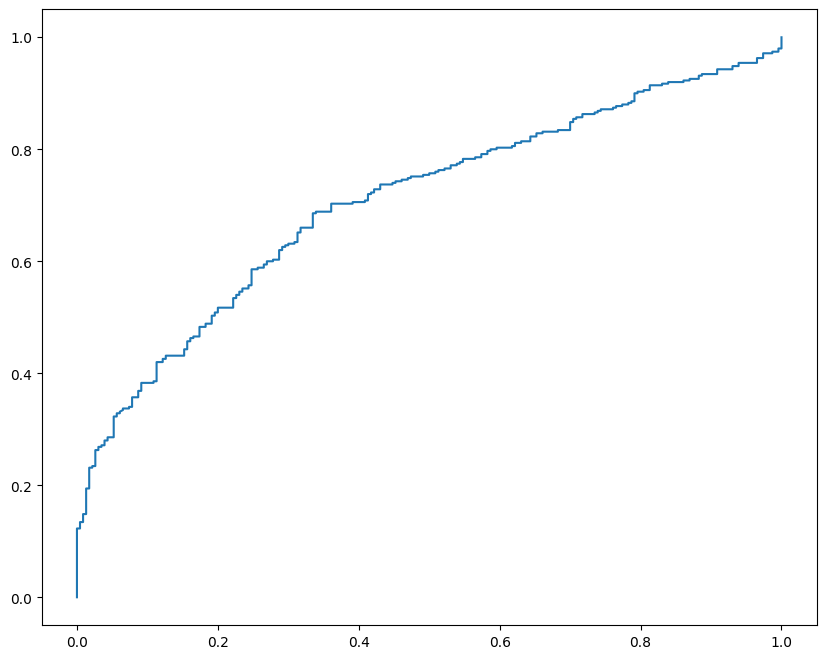